In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [4]:
caffe.set_mode_cpu();
model_def = caffe_root + 'models/bvlc_googlenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_googlenet/bvlc_googlenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR


mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
#net.blobs['data'].reshape(1,        # batch size
#                          3,         # 3-channel (BGR) images
#                          224, 224)  # image size is 227x227

In [16]:
image = caffe.io.load_image(caffe_root + 'examples/images/TrashBin/10.JPG')
transformed_image = transformer.preprocess('data', image)

# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.28050151,
  'n02747177 ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin'),
 (0.084643036, 'n04070727 refrigerator, icebox'),
 (0.067800499, 'n04265275 space heater'),
 (0.056319978, 'n03207941 dishwasher, dish washer, dishwashing machine'),
 (0.039719015, 'n04125021 safe')]

In [11]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(10, 3, 224, 224)
conv1/7x7_s2	(10, 64, 112, 112)
pool1/3x3_s2	(10, 64, 56, 56)
pool1/norm1	(10, 64, 56, 56)
conv2/3x3_reduce	(10, 64, 56, 56)
conv2/3x3	(10, 192, 56, 56)
conv2/norm2	(10, 192, 56, 56)
pool2/3x3_s2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(10, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(10, 192, 28, 28)
inception_3a/1x1	(10, 64, 28, 28)
inception_3a/3x3_reduce	(10, 96, 28, 28)
inception_3a/3x3	(10, 128, 28, 28)
inception_3a/5x5_reduce	(10, 16, 28, 28)
inception_3a/5x5	(10, 32, 28, 28)
inception_3a/pool	(10, 192, 28, 28)
inception_3a/pool_proj	(10, 32, 28, 28)
inception_3a/output	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(10, 256, 28, 28)
inception_3a/output_inception_3a/output_0_sp

In [12]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1/7x7_s2	(64, 3, 7, 7) (64,)
conv2/3x3_reduce	(64, 64, 1, 1) (64,)
conv2/3x3	(192, 64, 3, 3) (192,)
inception_3a/1x1	(64, 192, 1, 1) (64,)
inception_3a/3x3_reduce	(96, 192, 1, 1) (96,)
inception_3a/3x3	(128, 96, 3, 3) (128,)
inception_3a/5x5_reduce	(16, 192, 1, 1) (16,)
inception_3a/5x5	(32, 16, 5, 5) (32,)
inception_3a/pool_proj	(32, 192, 1, 1) (32,)
inception_3b/1x1	(128, 256, 1, 1) (128,)
inception_3b/3x3_reduce	(128, 256, 1, 1) (128,)
inception_3b/3x3	(192, 128, 3, 3) (192,)
inception_3b/5x5_reduce	(32, 256, 1, 1) (32,)
inception_3b/5x5	(96, 32, 5, 5) (96,)
inception_3b/pool_proj	(64, 256, 1, 1) (64,)
inception_4a/1x1	(192, 480, 1, 1) (192,)
inception_4a/3x3_reduce	(96, 480, 1, 1) (96,)
inception_4a/3x3	(208, 96, 3, 3) (208,)
inception_4a/5x5_reduce	(16, 480, 1, 1) (16,)
inception_4a/5x5	(48, 16, 5, 5) (48,)
inception_4a/pool_proj	(64, 480, 1, 1) (64,)
inception_4b/1x1	(160, 512, 1, 1) (160,)
inception_4b/3x3_reduce	(112, 512, 1, 1) (112,)
inception_4b/3x3	(224, 112, 3, 3) (224

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

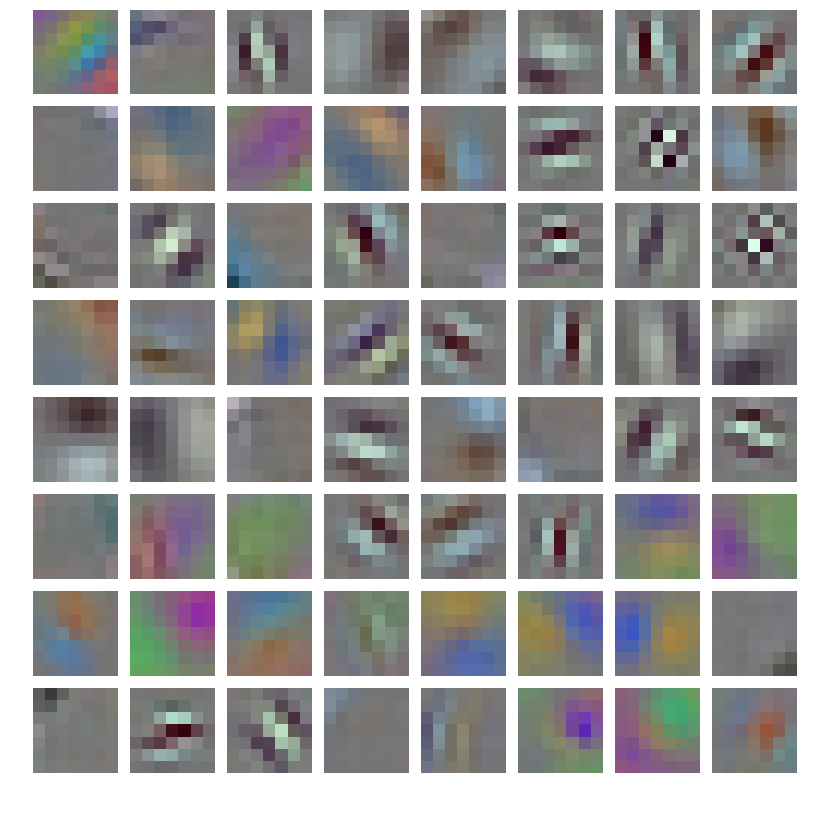

In [14]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1/7x7_s2'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

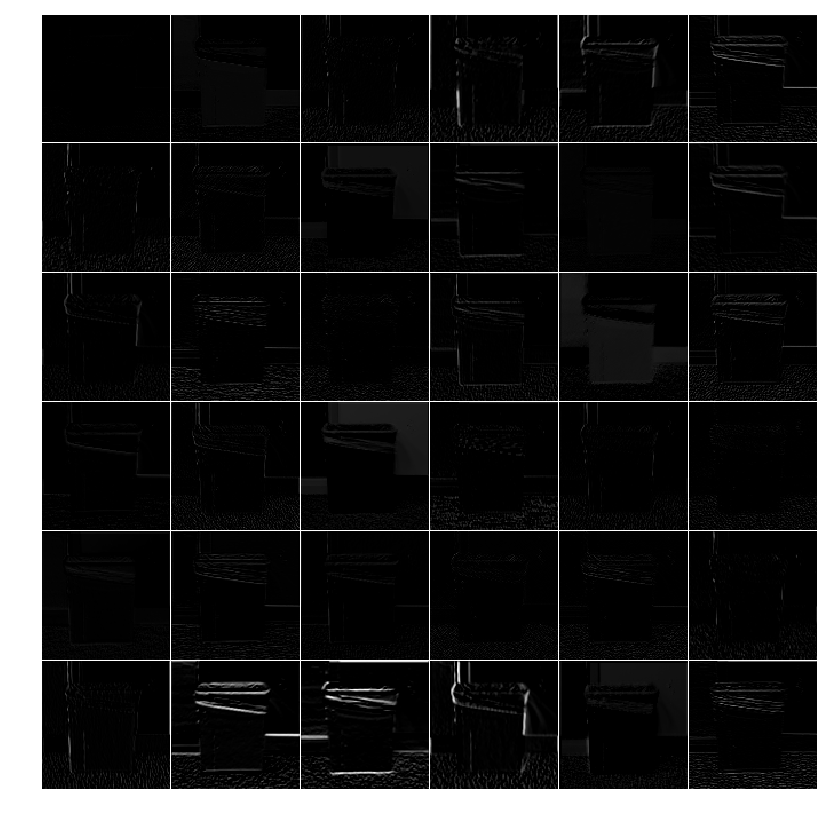

In [15]:
feat = net.blobs['conv1/7x7_s2'].data[0, :36]
vis_square(feat)